# Start
Hi Kaggle, this is my first notebook with some rudimentary ML classification after making my way through a few courses on Kaggle learn. I'm have an extensive background in software development with a little data analysis. The stories behind data are very interesting, especially the outliers. For instance, I found one category of passenger, I'm calling `comped` because they paid low fares, got good cabins, and all perished. Typically, high class tickets would have indicated a higher then ordinary chance of survival. It's very likely this is a quirk of the small sample size, but interesting to uncover. 

# Data Notes

In [182]:
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
# Variable Notes
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower
# age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
# sibsp: The dataset defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)
# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

In [183]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk
import seaborn as sns


# Data Import

In [184]:
# What are we working with?
X = pd.read_csv('train.csv')


print(X.dtypes)
X.head()


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing
Exploring the dataset we want to cast categories into numerical values and fix all the cabin NaNs. Then we can start looking for correlations.  

In [185]:

# Reusable preprocessing, for test time
def preprocess(df):
  ## Lowercase indices
  df.columns = df.columns.astype(str).str.lower()

  df['gender'] = df['sex'].map({'male':0, 'female':1})

  # bigger names = more important = survived?
  df['namelength'] = df.name.apply(lambda s: len(s))

  # get rid of string data in ticket numbers
  df['ticket'] = df.ticket.astype(str).str.rsplit(n=1)

  # remove decimals
  df['age'].fillna(df.age.mean(), inplace=True)
  df['fare'].fillna(df.fare.mean(), inplace=True)
  df['age'] = df.age.astype('int64')
  df['fare'] = df.fare.astype('int64')

  df.cabin.fillna('NONE', inplace=True)
  df['cabinType'] = df['cabin'].replace('/d+', '')
  # multiples are for families, select first for floor
  df['cabinType'] = df['cabinType'].str[0]

  # family size seems to negatively correlate with survival
  df['familySize'] = df['sibsp'] + df['parch']
  df.drop(['sibsp', 'parch'], axis=1, inplace=True)

  # categorize cabin floor 
  df.cabinType = pd.Categorical(df.cabinType)
  df['cabinCat'] = df.cabinType.cat.codes

  # categorize port
  df.embarked = pd.Categorical(df.embarked)
  df.embarked = df.embarked.cat.codes
  # 0 - C , 1 - q, 2 - s

  return df

X = preprocess(X)

# this number is only useful in the test phase
X.drop('passengerid', axis=1, inplace=True)



# Exploration
What can we uncover from the initial dataset.

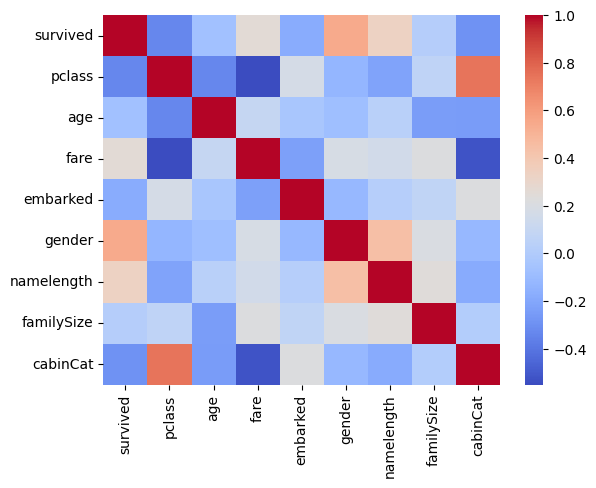

In [186]:
# what correlations can we find
sns.heatmap(X.corr(numeric_only=True), cmap='coolwarm')
plt.show()

# check survival distribution
Some of the correlations are clear, gender, fare, others require more investigation to see their impact. Interesting that the length of someone's name has an impact on their survival... 

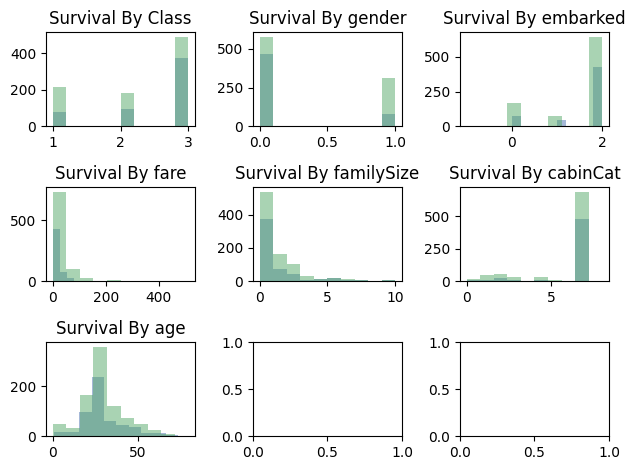

In [187]:
fig, axs = plt.subplots(nrows=3, ncols=3)

died = X[y == 0]

axs[0,0].hist(died['pclass'], alpha=0.5)
axs[0,0].hist(X['pclass'], alpha=0.5 )
axs[0,0].set_title('Survival By Class')

axs[0,1].hist(died['gender'], alpha=0.5)
axs[0,1].hist(X['gender'], alpha=0.5 )
axs[0,1].set_title('Survival By gender')

axs[0,2].hist(died['embarked'], alpha=0.5)
axs[0,2].hist(X['embarked'], alpha=0.5 )
axs[0,2].set_title('Survival By embarked')

axs[1,1].hist(died['familySize'], alpha=0.5) 
axs[1,1].hist(X['familySize'], alpha=0.5)
axs[1,1].set_title('Survival By familySize')

axs[1,2].hist(died['cabinCat'], alpha=0.5)
axs[1,2].hist(X['cabinCat'], alpha=0.5)
axs[1,2].set_title('Survival By cabinCat')

axs[1,0].hist(died['fare'], alpha=0.5)
axs[1,0].hist(X['fare'], alpha=0.5)
axs[1,0].set_title('Survival By fare')

axs[2,0].hist(died['age'], alpha=0.5)
axs[2,0].hist(X['age'], alpha=0.5)
axs[2,0].set_title('Survival By age')

plt.style.use('seaborn-v0_8-deep')
plt.tight_layout()
plt.show()

# Groups to explore
Different segments and how survival rates were impacted. Obvious ones here, like `gender` and `fare`, less intuitive are that having a large family leaves you less well off then paying less for a ticket, or that deck B would be well suited. 

In [188]:

# interesting groups
nocabin = X[X['cabin'] == 'NONE']
rich = X[X['fare'] > 100]
first = X[X['pclass'] == 1]
poor = X[X['fare'] < 10]
# b is best
bfloor = X[X['cabinCat'] == 2]
family = X[X['familySize'] > 3]

# 100% survival rate
notlucky = X[(X.cabinType == 'B') & (X.familySize < 2) & (X.gender == 1)]

# good cabins for dirt cheap, all died
c = X[X['pclass'] <= 2]
c= c[c['fare'] < 10 ]
comped = c

X.head()


,survived,pclass,name,sex,age,ticket,fare,cabin,embarked,gender,namelength,cabinType,familySize,cabinCat
0,0,3,"Braund, Mr. Owen Harris",male,22,"[A/5, 21171]",7,NONE,2,0,23,N,1,7
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,"[PC, 17599]",71,C85,0,1,51,C,1,2
2,1,3,"Heikkinen, Miss. Laina",female,26,"[STON/O2., 3101282]",7,NONE,2,1,22,N,0,7
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,[113803],53,C123,2,1,44,C,1,2
4,0,3,"Allen, Mr. William Henry",male,35,[373450],8,NONE,2,0,24,N,0,7


# Group Survival Rates

In [189]:
def calcSurvival(g):
    return g[g.survived==1].size /  g.size

print('nocabin', calcSurvival(nocabin))
print('richies', calcSurvival(rich))
print('firstclass', calcSurvival(first))
print('thirdclass', calcSurvival(third))
print('poors', calcSurvival(poor))
print('family', calcSurvival(family))
print('workers', calcSurvival(workers))
print('notlucky', calcSurvival(notlucky))
print('comped', calcSurvival(comped))
print('bfloor', calcSurvival(bfloor))
print('menwork', calcSurvival(maleworkers))
print('womenwork', calcSurvival(femaleworkers))


nocabin 0.29985443959243085
richies 0.7358490566037735
firstclass 0.6296296296296297
thirdclass 0.25
poors 0.19940476190476192
family 0.16129032258064516
workers 0.25
notlucky 1.0
comped 0.0
bfloor 0.5932203389830508
menwork nan
womenwork 0.3838383838383838


/var/folders/ty/_mwnwnjs0v3cyy4vdr2trx5m0000gn/T/ipykernel_8659/4191067909.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return g[g.survived==1].size /  g.size


# Define Target
Lets get into the modeling and prediction. Not trying anything fancy right now, just a basic workflow.

In [190]:
y = X['survived']

# Drop Target from dataset
X.drop('survived', axis=1, inplace=True)
# remove non numbers
X = X.select_dtypes(exclude=['object'])

# Model Validation

In [191]:
# Start
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

# ml setup
features = ['age','gender','pclass','age','familySize']
X = X[features]

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.8, random_state=42)
# model = DecisionTreeClassifier(random_state=42)
model = RandomForestClassifier(n_estimators=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print('MAE:', mean_absolute_error(y_val, y_pred))

MAE: 0.16201117318435754


# Full Model for Submission

In [192]:
model = RandomForestClassifier(n_estimators=5)
model.fit(X,y)

test_data = preprocess(pd.read_csv('test.csv'))
test_X = test_data[features]
test_pred = model.predict(test_X)


submit = pd.DataFrame({ 'PassengerId': test_data.passengerid, 'Survived': test_pred })
print(submit)

submit.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         1
3            895         1
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
